# Gesture Recognition
In this group project, you are going to build a CNN-RNN model with LSTM that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

start_time=time.time()

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
print('Tensorflow version: ',tf.__version__)
tf.random.set_seed(30)
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Tensorflow version:  2.3.1
Default GPU Device:/device:GPU:0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
BASE_PATH='../input/untouched-gesture-dataset'
#BASE_PATH='.'
train_doc = np.random.permutation(open(BASE_PATH+'/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(BASE_PATH+'/Project_data/val.csv').readlines())
BATCH_SIZE = 32 #experiment with the batch size
IMG_HEIGHT = 120
IMG_WIDTH = 120
LEARNING_RATE=0.0001
FRAMES=len(list(range(1,30,2)))
NUM_EPOCHS = 50
print('Number of frames being considered :',FRAMES)

Number of frames being considered : 15


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    # We will consider frames 10 to 20 for training
    img_idx = range(0,30,2) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list) / batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # second parameter x set to len(img_idx) list - indicates no. of images we want to use for each video
            # third and fourth parameters (y,z) indicate the final size of input image
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = tf.io.read_file(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = tf.io.decode_jpeg(image,channels=3)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # We will resize all the images to a standard shape of (120,120)
                    # We will use distinct normalization methods for different channel
                    im_resized = tf.image.resize(image,size=[IMG_HEIGHT,IMG_WIDTH],method='nearest') 
                    im_resized = tf.image.resize(tf.image.central_crop(im_resized,0.9),size=[IMG_HEIGHT,IMG_WIDTH],method='nearest')
                    im_resized_0 = im_resized[:,:,0]
                    im_resized_1 = im_resized[:,:,1]
                    im_resized_2 = im_resized[:,:,2]
                    batch_data[folder,idx,:,:,0] = (im_resized_0 - np.min(im_resized_0))/ (np.max(im_resized_0) - np.min(im_resized_0)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (im_resized_1 - np.percentile(im_resized_1,5))/ (np.percentile(im_resized_1,95) - np.percentile(im_resized_1,5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = im_resized_2/255 #normalise and feed in the image                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) != (num_batches * batch_size):
            n_batch_size = len(folder_list) - (num_batches * batch_size)
            batch_data = np.zeros((n_batch_size,len(img_idx),120,120,3))
            batch_labels = np.zeros((n_batch_size,5))
            for folder in range(n_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*n_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = tf.io.read_file(source_path+'/'+ t[folder + (num_batches*n_batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = tf.io.decode_jpeg(image,channels=3)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # We will resize all the images to a standard shape of (120,120)
                    # We will use distinct normalization methods for different channel
                    im_resized = tf.image.resize(image,size=[IMG_HEIGHT,IMG_WIDTH],method='nearest') 
                    im_resized = tf.image.resize(tf.image.central_crop(im_resized,0.9),size=[IMG_HEIGHT,IMG_WIDTH],method='nearest')
                    im_resized_0 = im_resized[:,:,0]
                    im_resized_1 = im_resized[:,:,1]
                    im_resized_2 = im_resized[:,:,2]
                    batch_data[folder,idx,:,:,0] = (im_resized_0 - np.min(im_resized_0))/ (np.max(im_resized_0) - np.min(im_resized_0)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (im_resized_1 - np.percentile(im_resized_1,5))/ (np.percentile(im_resized_1,95) - np.percentile(im_resized_1,5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = im_resized_2/255 #normalise and feed in the image   
                    
                batch_labels[folder, int(t[folder + (num_batches*n_batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
from PIL import Image

curr_dt_time = datetime.datetime.now()
train_path = BASE_PATH+'/Project_data/train'
val_path = BASE_PATH+'/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
print('# training batches =', int(num_train_sequences/30))
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

img_sizes=[]
for i in os.listdir(train_path):
    if not(i.startswith('.')):
        file_path = train_path + "/" + i
        for j in os.listdir(file_path):
            if not(j.startswith('.')):
                im_path = file_path + "/" + j
                im = Image.open(im_path)
                img_sizes.append(im.size)

# training sequences = 663
# training batches = 22
# validation sequences = 100


In [6]:
set(img_sizes)

{(160, 120), (360, 360)}

As we can see we have two shapes of images (160,120) and (360,360).  We will standardize the image shapes to (120,120)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Conv3D Model

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

#write your model here
nb_filters = [8,16,32,64]
nb_dense = [1000, 500, 5]
input_shape = (FRAMES, 120, 120, 3)

model_b = Sequential()

model_b.add(TimeDistributed(Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same'),
                            input_shape=input_shape))
model_b.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model_b.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2,2))))

model_b.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_b.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_b.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
        
model_b.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model_b.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_b.add(TimeDistributed(Flatten()))

model_b.add(Dropout(0.5))
model_b.add(GRU(256, return_sequences=False, dropout=0.5))

#output layer
model_b.add(Dense(nb_dense[2], activation='sigmoid'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimizer=optimizers.Adam(lr=LEARNING_RATE)
model_b.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy']) 
print (model_b.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 60, 60, 32)    896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 29, 29, 64)    36928     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 14, 14, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 14, 14, 128)   7

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, BATCH_SIZE)
val_generator = generator(val_path, val_doc, BATCH_SIZE)

In [10]:
filepath = 'best_model.h5'

mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min',
                        min_delta=0.0001, cooldown=0, min_lr=0) 
callbacks_list = [mc, lr, es]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%BATCH_SIZE) == 0:
    steps_per_epoch = int(num_train_sequences/BATCH_SIZE)
else:
    steps_per_epoch = (num_train_sequences//BATCH_SIZE) + 1

if (num_val_sequences%BATCH_SIZE) == 0:
    validation_steps = int(num_val_sequences/BATCH_SIZE)
else:
    validation_steps = (num_val_sequences//BATCH_SIZE) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
21/21 [==============================] - 124s 6s/step - loss: 0.5726 - binary_accuracy: 0.7828 - val_loss: 0.5180 - val_binary_accuracy: 0.8000
Epoch 2/50
21/21 [==============================] - 114s 5s/step - loss: 0.5092 - binary_accuracy: 0.8000 - val_loss: 0.5014 - val_binary_accuracy: 0.8000
Epoch 3/50
21/21 [==============================] - 113s 5s/step - loss: 0.5057 - binary_accuracy: 0.8000 - val_loss: 0.5016 - val_binary_accuracy: 0.8000
Epoch 4/50
21/21 [==============================] - 113s 5s/step - loss: 0.5035 - binary_accuracy: 0.8000 - val_loss: 0.4983 - val_binary_accuracy: 0.8000
Epoch 5/50
21/21 [==============================] - 114s 5s/step - loss: 0.5046 - binary_accuracy: 0.8000 - val_loss: 0.4979 - val_binary_accuracy: 0.8000
Epoch 6/50
21/21 [==============================] - 118s 6s/step - loss: 0.5015 - binary_accuracy: 0.8000 - val_loss: 0.4929 - val_binary_accuracy: 0.8000
Epoch 7/50
21/21 [==============================] - 108s 5s/step - los

Plot the train and validation loss and accuracies

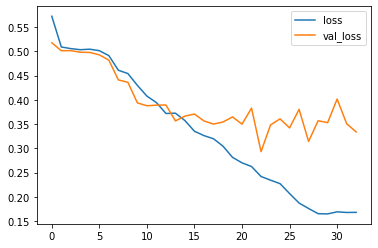

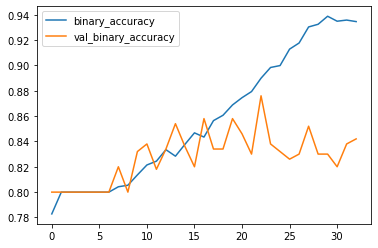

In [13]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [14]:
# Display the exeuction time
print('Total execution time is :',round((time.time() - start_time)/60),'minutes')

Total execution time is : 64 minutes
